In [ ]:
#step-1 importing libraries

import pandas as pd #handle data like spreadsheet
import numpy as np #math operations
import matplotlib.pyplot as plt
import seaborn as sns #to make preety charts
from sklearn.model_selection import train_test_split  #machine learning tools
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
from xgboost import XGBRegressor #our pricing prediction algorithm
import warnings
warnings.filterwarnings('ignore')


In [2]:
#step-2 loading data

df = pd.read_csv('retail_price.csv')

print("Data Loaded! Here's what we have:\n")
print(df.head())

print(f"\nDataset size: {df.shape[0]} rows x {df.shape[1]} columns")

print("\nColumn details:")
print(df.info())

Data Loaded! Here's what we have:

  product_id product_category_name  month_year  qty  total_price  \
0       bed1        bed_bath_table  01-05-2017    1        45.95   
1       bed1        bed_bath_table  01-06-2017    3       137.85   
2       bed1        bed_bath_table  01-07-2017    6       275.70   
3       bed1        bed_bath_table  01-08-2017    4       183.80   
4       bed1        bed_bath_table  01-09-2017    2        91.90   

   freight_price  unit_price  product_name_lenght  product_description_lenght  \
0      15.100000       45.95                   39                         161   
1      12.933333       45.95                   39                         161   
2      14.840000       45.95                   39                         161   
3      14.287500       45.95                   39                         161   
4      15.100000       45.95                   39                         161   

   product_photos_qty  ...  comp_1  ps1        fp1      comp_2  ps2  

Unit Price Statistics:
count    676.000000
mean     106.496800
std       76.182972
min       19.900000
25%       53.900000
50%       89.900000
75%      129.990000
max      364.000000
Name: unit_price, dtype: float64


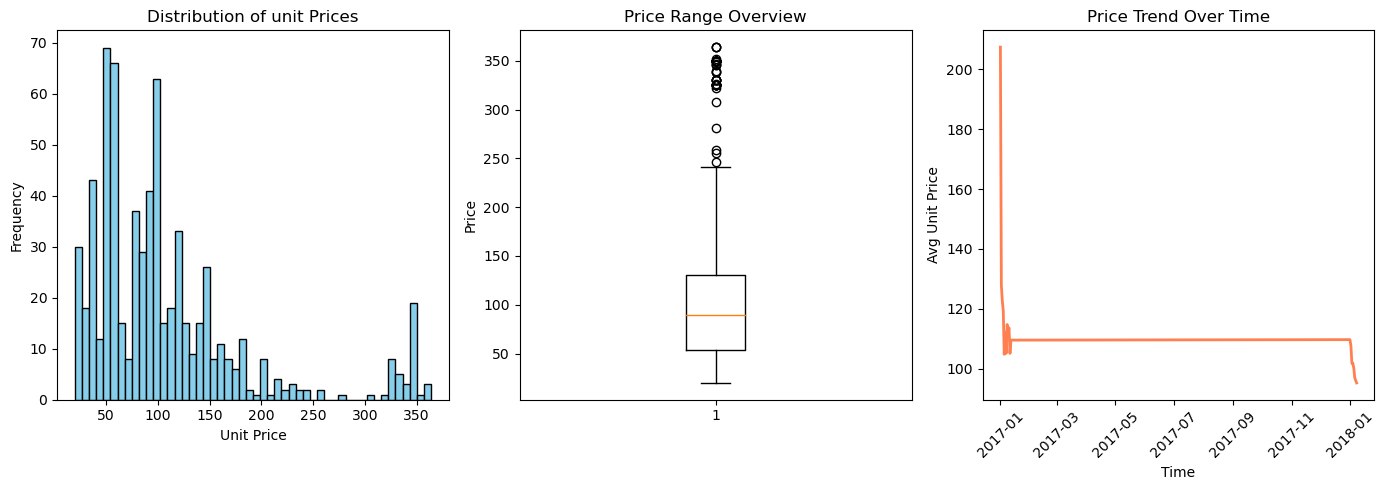


Missing values:
product_id                    0
product_category_name         0
month_year                    0
qty                           0
total_price                   0
freight_price                 0
unit_price                    0
product_name_lenght           0
product_description_lenght    0
product_photos_qty            0
product_weight_g              0
product_score                 0
customers                     0
weekday                       0
weekend                       0
holiday                       0
month                         0
year                          0
s                             0
volume                        0
comp_1                        0
ps1                           0
fp1                           0
comp_2                        0
ps2                           0
fp2                           0
comp_3                        0
ps3                           0
fp3                           0
lag_price                     0
dtype: int64

Corealati

In [3]:
#Basic statistics 
print("Unit Price Statistics:")
print(df['unit_price'].describe())

#visualize price distribution
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.hist(df['unit_price'], bins =50, color='skyblue', edgecolor='black')
plt.xlabel('Unit Price')
plt.ylabel('Frequency')
plt.title('Distribution of unit Prices')

plt.subplot(1,3,2)
plt.boxplot(df['unit_price'])
plt.ylabel('Price')
plt.title('Price Range Overview')

plt.subplot(1,3,3)

df_time =df.copy()

df_time['month_year'] = pd.to_datetime(df_time['month_year'])
df_time = df_time.sort_values('month_year')
plt.plot(df_time.groupby('month_year')['unit_price'].mean(), color='coral',linewidth=2)
plt.xlabel('Time')
plt.ylabel('Avg Unit Price')
plt.title('Price Trend Over Time')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\nMissing values:")
print(df.isnull().sum())

print("\nCorealation with competitor prices:")
print(df[['unit_price','comp_1','comp_2','comp_3']].corr())

In [4]:
#step-4 Enigeer smart features
data =df.copy()
print("Creating smart pricing features...")

#feature 1: AVERAGE competitor price
data['avg_competitor_price'] = data[['comp_1','comp_2','comp_3']].mean(axis=1)

#feautre 2: minimum and maximum competitor prices

data['min_competitor_price'] =data[['comp_1','comp_2','comp_3']].min(axis=1)
data['max_competitor_price'] =data[['comp_1','comp_2','comp_3']].max(axis=1)

#feature 3: Price difference from competitors
data['price_vs_comp1'] = data['unit_price'] - data['comp_1']
data['price_vs_comp2'] = data['unit_price'] - data['comp_2']
data['price_vs_comp3'] = data['unit_price'] - data['comp_3']

data['price_vs_avg_comp'] = data['unit_price'] - data['avg_competitor_price']


#feature 4: Competition intensity (price range among competitors)
data['comp_price_range'] = data['max_competitor_price'] - data['min_competitor_price']

#feature 5: Average competitor product score
data['avg_comp_score'] = data[['ps1','ps2','ps3']].mean(axis=1)

#feature 6: Average competitor freight price 
data['avg_comp_freight'] = data[['fp1','fp2','fp3']].mean(axis=1)

#feature 7: Price change fro lag(trend)
data['price_change'] = data['unit_price'] - data['lag_price']
data['price_change_pct'] = ((data['unit_price'] - data['lag_price']))

#feature 8 :is it weekend or holiday
data['is_holiday_or_weekend'] = ((data['holiday'] ==1 )|(data['weekend'] ==1)).astype(int)

#feature 9: price per volume 
data['price_per_volume'] = data['unit_price'] /(data['volume']+1)

#feature 10: Revenue(price x quantity)
data['revenue'] = data['unit_price'] * data['qty']

#feature 11: Average freight price
data['avg_freight'] = (data['freight_price'] + data['avg_comp_freight'])/2

#feature 12: Product value indicator (price xscore)
data['value_score'] = data['unit_price'] * data['product_score']

print("New features created!")

print(f"Total fetures now: {data.shape[1]}")
print(f"\nNew feature names:")
new_features = [col for col in data.columns if col not in df.columns]
for feat in new_features:
    print(f"  • {feat}")

Creating smart pricing features...
New features created!
Total fetures now: 47

New feature names:
  • avg_competitor_price
  • min_competitor_price
  • max_competitor_price
  • price_vs_comp1
  • price_vs_comp2
  • price_vs_comp3
  • price_vs_avg_comp
  • comp_price_range
  • avg_comp_score
  • avg_comp_freight
  • price_change
  • price_change_pct
  • is_holiday_or_weekend
  • price_per_volume
  • revenue
  • avg_freight
  • value_score


In [5]:
#preapring data for learning

features_to_drop =[
    'unit_price', #target varaible
    'product_id', # just an id
    'product_category_name', #TExt
    'month_year', 
    'total_price',
    
]

featrues_to_drop =[col for col in features_to_drop if col in data.columns]

X = data.drop(columns = features_to_drop)
y = data['unit_price']

X = X.fillna(X.median())

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures we're using ({X.shape[1]} total):")

X_train,X_test ,y_train,y_test = train_test_split(
X,y,test_size =0.2 ,random_state =42
)

print(f"\nTraining set: {X.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

Features shape: (676, 42)
Target shape: (676,)

Features we're using (42 total):

Training set: 676 samples
Test set: 136 samples


In [6]:
#traing the model using XGboost model Focuses on hard examples ● Handles imbalance well ● Works great for tabular data
from xgboost import XGBRegressor

model = XGBRegressor( 
    n_estimators =200,
    learning_rate =0.05,
    max_depth =6,
    min_child_weight =3,    # Minimum data points in a leaf
    subsample =0.8,         # Use 80% of data for each tree
    colsample_bytree =0.8,  # Use 80% of features for each tree
    random_state =42,
    n_jobs = -1
)

print("Trainig the model...")
print("This might take a minute..\n")

model.fit(X_train,y_train,eval_set =[(X_train,y_train),(X_test,y_test)],verbose =50)
#We use eval_set during fitting to monitor model performance on unseen data in real time, detect overfitting, and enable early stopping. Normal fitting trains the model, but doesn’t give insight into how well it generalizes

print("\n model trained succesfully!")

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("\nSample predicitons vs actual prices:")
comparision = pd.DataFrame({
    'Actual price':y_test.head(10).values,
    'Predicted Price': y_test_pred[:10],
    'Difference': y_test.head(10).values - y_test_pred[:10],
    'Error%': ((y_test.head(10).values - y_test_pred[:10])/ y_test.head(10).values * 100)
})
print(comparision.to_string(index=False))

Trainig the model...
This might take a minute..

[0]	validation_0-rmse:72.99000	validation_1-rmse:70.56875
[50]	validation_0-rmse:6.78861	validation_1-rmse:6.88096
[100]	validation_0-rmse:1.01157	validation_1-rmse:3.09911
[150]	validation_0-rmse:0.36884	validation_1-rmse:2.96958
[199]	validation_0-rmse:0.24725	validation_1-rmse:2.94376

 model trained succesfully!

Sample predicitons vs actual prices:
 Actual price  Predicted Price  Difference    Error%
   174.433333       177.894699   -3.461366 -1.984349
   129.990000       129.735916    0.254084  0.195464
    99.900000       100.074326   -0.174326 -0.174500
    77.821429        77.916901   -0.095472 -0.122681
    99.990000       100.024529   -0.034529 -0.034532
    52.900000        54.048161   -1.148161 -2.170436
   151.878437       160.910843   -9.032405 -5.947128
    53.379104        51.437317    1.941788  3.637730
    45.900000        46.075863   -0.175863 -0.383144
   105.000000       105.125557   -0.125557 -0.119578


In [7]:
import joblib

joblib.dump(model, "xgb_price_model.pkl")
joblib.dump(X.columns.tolist(), "feature_columns.pkl")


['feature_columns.pkl']

In [8]:
#step 7:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test,y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train,y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test,y_test_pred)

print("=" * 60)
print("Model Performace Report")
print("=" * 60)

print(f"\n Training set:")
print(f"  MAE(Mean Absolute Error):   ${train_mae:.2f}")
print(f"  RMSE (Root Mean Squared Error):    ${train_rmse:.2f}")
print(f"  R² Score:   {train_r2:.4f}")

print(f"\n TEST SET (Unseen Data):")
print(f"   MAE:      ${test_mae:.2f}")
print(f"   RMSE:     ${test_rmse:.2f}")
print(f"   R² Score: {test_r2:.4f}")

# Calculate percentage accuracy
avg_price = y_test.mean()
accuracy_pct = (1 - test_mae/avg_price) * 100

print(f"\n Model Insights:")
print(f"   Average actual price:     ${avg_price:.2f}")
print(f"   Average prediction error: ${test_mae:.2f}")
print(f"   Accuracy:                 {accuracy_pct:.1f}%")
print(f"   Variance explained:       {test_r2*100:.1f}%")

# Check for overfitting
print(f"\n Overfitting Check:")
mae_diff = train_mae - test_mae
rmse_diff = train_rmse - test_rmse
print(f"   MAE difference (train-test):  ${mae_diff:.2f}")
print(f"   RMSE difference (train-test): ${rmse_diff:.2f}")
if abs(mae_diff) < test_mae * 0.1:
    print(f"    Model generalizes well! No significant overfitting.")
else:
    print(f"    Some overfitting detected. Consider regularization.")

print("=" * 60)


Model Performace Report

 Training set:
  MAE(Mean Absolute Error):   $0.17
  RMSE (Root Mean Squared Error):    $0.25
  R² Score:   1.0000

 TEST SET (Unseen Data):
   MAE:      $1.32
   RMSE:     $2.94
   R² Score: 0.9984

 Model Insights:
   Average actual price:     $98.95
   Average prediction error: $1.32
   Accuracy:                 98.7%
   Variance explained:       99.8%

 Overfitting Check:
   MAE difference (train-test):  $-1.15
   RMSE difference (train-test): $-2.70
    Some overfitting detected. Consider regularization.


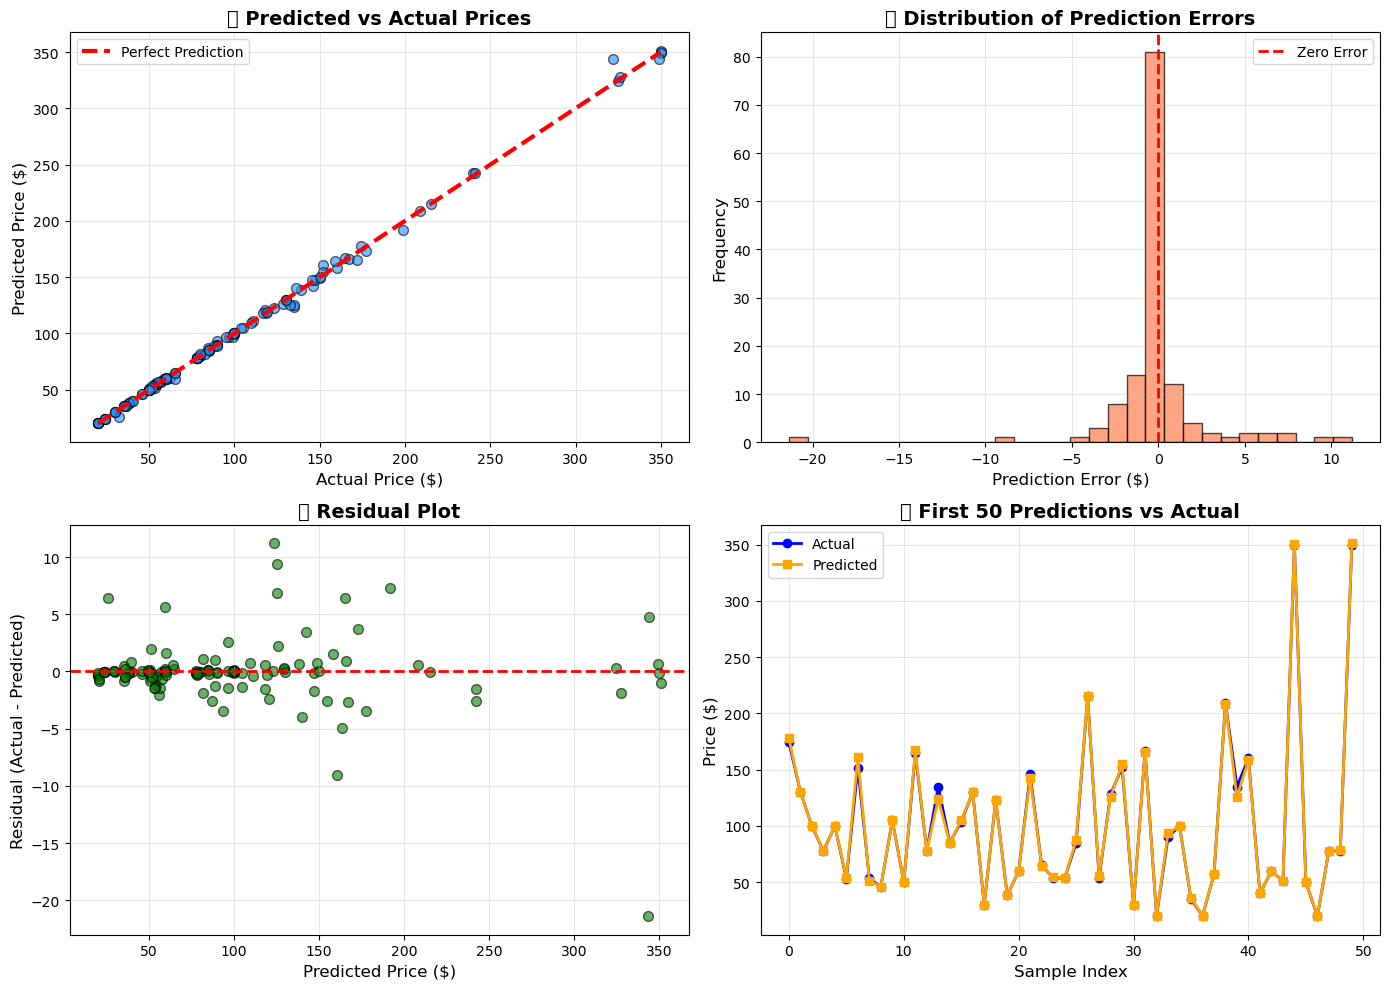

✅ Error statistics:
   Mean error:     $-0.05
   Std deviation:  $2.95
   Min error:      $-21.37
   Max error:      $11.18


In [9]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Predicted vs Actual (Scatter)
axes[0, 0].scatter(y_test, y_test_pred, alpha=0.6, color='dodgerblue', edgecolor='black', s=50)
axes[0, 0].plot([y_test.min(), y_test.max()], 
                [y_test.min(), y_test.max()], 
                'r--', lw=3, label='Perfect Prediction')
axes[0, 0].set_xlabel('Actual Price ($)', fontsize=12)
axes[0, 0].set_ylabel('Predicted Price ($)', fontsize=12)
axes[0, 0].set_title('🎯 Predicted vs Actual Prices', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Prediction errors distribution
errors = y_test - y_test_pred
axes[0, 1].hist(errors, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].set_xlabel('Prediction Error ($)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('📊 Distribution of Prediction Errors', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Residual plot
axes[1, 0].scatter(y_test_pred, errors, alpha=0.6, color='green', edgecolor='black', s=50)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Predicted Price ($)', fontsize=12)
axes[1, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=12)
axes[1, 0].set_title('🔍 Residual Plot', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Actual vs Predicted (Line plot)
indices = range(len(y_test[:50]))
axes[1, 1].plot(indices, y_test.head(50).values, 'o-', label='Actual', color='blue', linewidth=2, markersize=6)
axes[1, 1].plot(indices, y_test_pred[:50], 's-', label='Predicted', color='orange', linewidth=2, markersize=6)
axes[1, 1].set_xlabel('Sample Index', fontsize=12)
axes[1, 1].set_ylabel('Price ($)', fontsize=12)
axes[1, 1].set_title('📉 First 50 Predictions vs Actual', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Error statistics:")
print(f"   Mean error:     ${errors.mean():.2f}")
print(f"   Std deviation:  ${errors.std():.2f}")
print(f"   Min error:      ${errors.min():.2f}")
print(f"   Max error:      ${errors.max():.2f}")

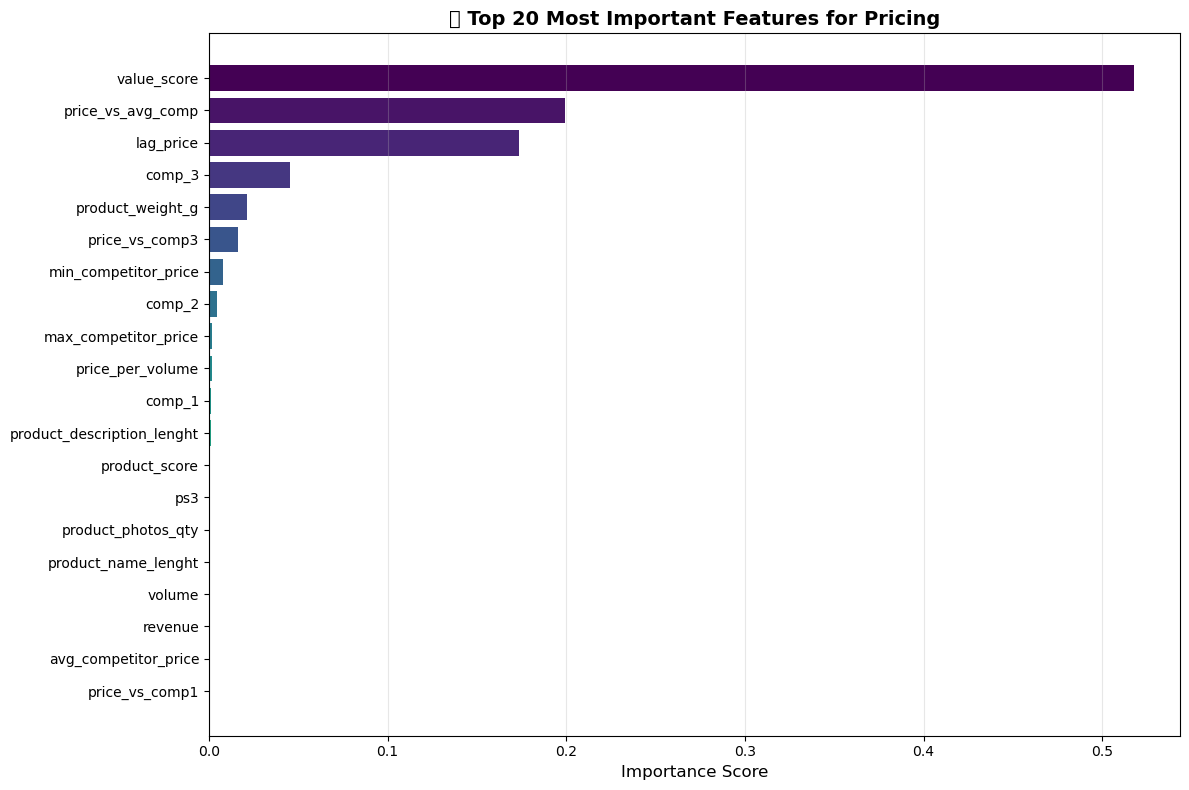


🏆 Top 15 Features:
                   Feature  Importance
               value_score    0.517640
         price_vs_avg_comp    0.199559
                 lag_price    0.173393
                    comp_3    0.045223
          product_weight_g    0.021369
            price_vs_comp3    0.016327
      min_competitor_price    0.007772
                    comp_2    0.004655
      max_competitor_price    0.001827
          price_per_volume    0.001751
                    comp_1    0.001271
product_description_lenght    0.001060
             product_score    0.000864
                       ps3    0.000854
        product_photos_qty    0.000727

💡 Insights:
   The top 5 drivers of price are:
      1. value_score
      2. price_vs_avg_comp
      3. lag_price
      4. comp_3
      5. product_weight_g


In [10]:
# Get feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(12, 8))
top_features = importance_df.head(20)
colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
plt.barh(range(len(top_features)), top_features['Importance'], color=colors)
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title('🌟 Top 20 Most Important Features for Pricing', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n🏆 Top 15 Features:")
print(importance_df.head(15).to_string(index=False))

# Feature importance insights
print("\n💡 Insights:")
top_5 = importance_df.head(5)['Feature'].tolist()
print(f"   The top 5 drivers of price are:")
for i, feat in enumerate(top_5, 1):
    print(f"      {i}. {feat}")

In [11]:
def predict_new_price(input_data: dict, model, feature_columns):
    """
    input_data: dictionary of raw feature values
    model: trained XGBRegressor
    feature_columns: list of feature names used during training
    """
    input_df = pd.DataFrame([input_data])

    # Ensure correct column order
    input_df = input_df.reindex(columns=feature_columns, fill_value=0)

    prediction = model.predict(input_df)[0]
    return prediction


In [12]:
new_product = {
    'qty': 10,
    'freight_price': 15,
    'product_name_lenght': 40,
    'product_description_lenght': 300,
    'product_photos_qty': 2,
    'product_weight_g': 500,
    'product_score': 4.5,
    'customers': 200,
    'weekday': 1,
    'weekend': 0,
    'holiday': 0,
    'month': 6,
    'year': 2024,
    's': 1.2,
    'volume': 20,
    'comp_1': 105,
    'ps1': 4.3,
    'fp1': 14,
    'comp_2': 110,
    'ps2': 4.4,
    'fp2': 15,
    'comp_3': 108,
    'ps3': 4.2,
    'fp3': 13,
    'lag_price': 102,

    # engineered features
    'avg_competitor_price': 107.6,
    'min_competitor_price': 105,
    'max_competitor_price': 110,
    'price_vs_comp1': -3,
    'price_vs_comp2': -8,
    'price_vs_comp3': -6,
    'price_vs_avg_comp': -5.6,
    'comp_price_range': 5,
    'avg_comp_score': 4.3,
    'avg_comp_freight': 14,
    'price_change': 3,
    'price_change_pct': 3,
    'is_holiday_or_weekend': 0,
    'price_per_volume': 5.1,
    'revenue': 1020,
    'avg_freight': 14.5,
    'value_score': 459
}

predicted_price = predict_new_price(
    new_product,
    model,
    X.columns
)

print(f"💰 Predicted Optimal Price: ${predicted_price:.2f}")


💰 Predicted Optimal Price: $110.01


2026-02-02 18:11:35.126 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:35.127 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.375 
  command:

    streamlit run C:\Users\krish\anaconda\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2026-02-02 18:11:36.375 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.376 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.379 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.379 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when runni

2026-02-02 18:11:36.553 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.554 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.560 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.562 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.571 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.573 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.596 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-02 18:11:36.597 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

DeltaGenerator()

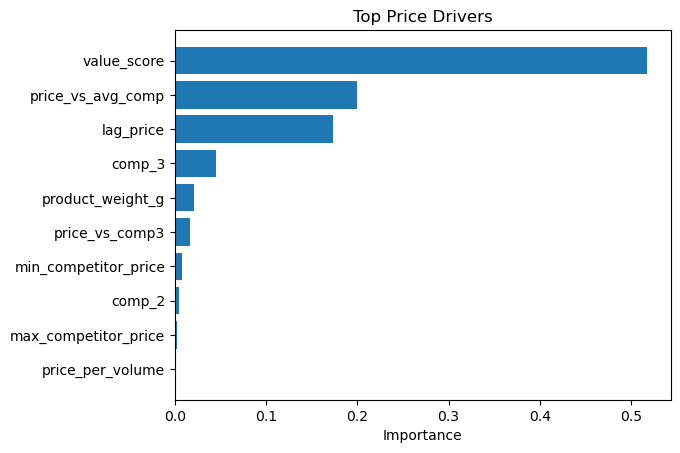

In [13]:
import streamlit as st
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# --------------------------------------------------
# App Configuration
# --------------------------------------------------
st.set_page_config(
    page_title="🛒 Retail Price Predictor",
    layout="wide"
)

st.title("🛒 Smart Retail Price Prediction")
st.markdown(
    """
    This tool helps you **estimate a fair product price** using historical data,
    competitor prices, and demand patterns.

    👉 **No technical knowledge needed**  
    👉 If you're unsure, just select **“I'm not sure”**  
    👉 All values have **safe default assumptions**
    """
)

# --------------------------------------------------
# Load Model & Features
# --------------------------------------------------
@st.cache_resource
def load_model():
    model = joblib.load("xgb_price_model.pkl")
    features = joblib.load("feature_columns.pkl")
    return model, features

model, feature_columns = load_model()

# --------------------------------------------------
# Sidebar – User Inputs
# --------------------------------------------------
st.sidebar.header("📥 Enter Product Details")

st.sidebar.markdown(
    "💡 **Tip:** If you’re unsure about any input, keep the default value."
)

# ---------- SECTION 1: Product Basics ----------
st.sidebar.subheader("📦 Product Basics")

qty = st.sidebar.slider(
    "Approximate Quantity Sold",
    min_value=1,
    max_value=500,
    value=10,
    help="How many units are typically sold together"
)

product_score = st.sidebar.slider(
    "Product Rating (1–5)",
    1.0, 5.0, 4.3,
    help="Average customer rating of the product"
)

product_weight_g = st.sidebar.selectbox(
    "Product Weight",
    ["I'm not sure", "Very Light", "Light", "Medium", "Heavy"],
    help="Select an approximate weight category"
)

weight_map = {
    "I'm not sure": 800,
    "Very Light": 300,
    "Light": 600,
    "Medium": 1000,
    "Heavy": 2000
}
product_weight_g = weight_map[product_weight_g]

# ---------- SECTION 2: Timing & Demand ----------
st.sidebar.subheader("📅 Timing & Demand")

weekend = st.sidebar.toggle(
    "Is it a Weekend?",
    help="Weekends usually have higher demand"
)

holiday = st.sidebar.toggle(
    "Is it a Holiday?",
    help="Holidays may allow higher pricing"
)

month = st.sidebar.selectbox(
    "Month",
    list(range(1, 13)),
    index=5,
    help="Month of the year"
)

# ---------- SECTION 3: Competitor Pricing ----------
st.sidebar.subheader("🏷️ Competitor Prices")

st.sidebar.markdown(
    "Enter **rough competitor prices**. Exact values are not required."
)

comp_1 = st.sidebar.slider("Competitor 1 Price", 10.0, 500.0, 100.0)
comp_2 = st.sidebar.slider("Competitor 2 Price", 10.0, 500.0, 105.0)
comp_3 = st.sidebar.slider("Competitor 3 Price", 10.0, 500.0, 98.0)

# ---------- SECTION 4: Past Price ----------
st.sidebar.subheader("📈 Past Pricing")

lag_price = st.sidebar.slider(
    "Last Known Price",
    10.0, 500.0, 95.0,
    help="Previous selling price (if known)"
)

# Reset Button
if st.sidebar.button("🔄 Reset All Inputs"):
    st.experimental_rerun()

# --------------------------------------------------
# Feature Engineering (Beginner-safe)
# --------------------------------------------------
avg_comp_price = np.mean([comp_1, comp_2, comp_3])
min_comp_price = min(comp_1, comp_2, comp_3)
max_comp_price = max(comp_1, comp_2, comp_3)

input_data = {
    "qty": qty,
    "product_score": product_score,
    "product_weight_g": product_weight_g,
    "weekend": int(weekend),
    "holiday": int(holiday),
    "month": month,
    "comp_1": comp_1,
    "comp_2": comp_2,
    "comp_3": comp_3,
    "lag_price": lag_price,

    # Engineered features
    "avg_competitor_price": avg_comp_price,
    "min_competitor_price": min_comp_price,
    "max_competitor_price": max_comp_price,
    "price_vs_comp1": lag_price - comp_1,
    "price_vs_comp2": lag_price - comp_2,
    "price_vs_comp3": lag_price - comp_3,
    "price_vs_avg_comp": lag_price - avg_comp_price,
    "comp_price_range": max_comp_price - min_comp_price,
    "is_holiday_or_weekend": int(holiday or weekend),
}

# Convert to DataFrame
input_df = pd.DataFrame([input_data])
input_df = input_df.reindex(columns=feature_columns, fill_value=0)

# --------------------------------------------------
# Prediction
# --------------------------------------------------
st.markdown("---")
st.subheader("🔮 Price Prediction")

if st.button("💰 Predict Price"):
    prediction = model.predict(input_df)[0]

    # Simple confidence logic
    price_gap = abs(prediction - avg_comp_price)

    if price_gap < 5:
        confidence = "High"
    elif price_gap < 15:
        confidence = "Medium"
    else:
        confidence = "Low"

    st.success(f"💰 **Recommended Price:** ${prediction:.2f}")
    st.info(f"📊 **Confidence Level:** {confidence}")

    st.markdown(
        f"""
        **What this means:**
        - The model suggests pricing near **${prediction:.2f}**
        - Based on competitor pricing and demand signals
        - Suitable for current market conditions
        """
    )

# --------------------------------------------------
# Feature Importance Visualization
# --------------------------------------------------
st.markdown("---")
st.subheader("📊 What Influences the Price Most?")

importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False).head(10)

fig, ax = plt.subplots()
ax.barh(importance_df["Feature"], importance_df["Importance"])
ax.invert_yaxis()
ax.set_xlabel("Importance")
ax.set_title("Top Price Drivers")

st.pyplot(fig)

# --------------------------------------------------
# Footer
# --------------------------------------------------
st.markdown(
    """
    ---
    ⚠️ **Note:**  
    This tool provides **decision support**, not exact pricing guarantees.  
    Always consider business strategy and market context.
    """
)


In [ ]:
!streamlit run app.py